In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import Sequential, regularizers 

from keras.layers import Embedding, LSTM, Dense
from keras import losses
from keras.layers import Dense
from keras.layers import Flatten, InputLayer

import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics
import plotly.express as px

In [ ]:
path_df = "/content/drive/MyDrive/fake_bert/politifact_global_feature.pkl"

In [ ]:
df = pickle.load(open(path_df, "rb"))

In [ ]:
fea_st_col = df.iloc[:, 10:10 + 14 + 13].columns
fea_sen_col = df.iloc[:, 10 + 14 + 13 + 6:10 + 14 + 13 + 6 + 19].columns
union_cols = fea_st_col.union(fea_sen_col)
fea_sts_df = df[union_cols]

In [ ]:
x_train, x_test, y_train, y_test, f_train, f_test = train_test_split(df['comp_text'], df['target'], fea_sts_df, test_size= .20, random_state= 111, shuffle=False )

In [ ]:
embed_train, embed_test = pickle.load(open("/content/drive/MyDrive/fake_bert/sbert-embed.pkl", "rb"))

In [ ]:
scaler = preprocessing.MinMaxScaler()
f_train_transform = scaler.fit_transform(f_train)
f_test_transform = scaler.fit_transform(f_test)

In [ ]:
merged_train_arr = np.hstack([embed_train, f_train_transform])

In [ ]:
merged_test_arr = np.hstack([embed_test, f_test_transform])

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
cv=5
gs_xgb = XGBClassifier()

param_grid = [
    {'booster':['gbtree', 'dart'], 'n_estimators':[100, 150, 200, 250], 'max_depth':[5, 6, 7]}
]
grid = GridSearchCV(gs_xgb, param_grid, refit=True, cv=cv, verbose=3, scoring='roc_auc')
            

In [ ]:
grid.fit(merged_train_arr, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END booster=gbtree, max_depth=5, n_estimators=100;, score=0.838 total time=   1.1s
[CV 2/5] END booster=gbtree, max_depth=5, n_estimators=100;, score=0.874 total time=   1.1s
[CV 3/5] END booster=gbtree, max_depth=5, n_estimators=100;, score=0.837 total time=   1.1s
[CV 4/5] END booster=gbtree, max_depth=5, n_estimators=100;, score=0.906 total time=   1.1s
[CV 5/5] END booster=gbtree, max_depth=5, n_estimators=100;, score=0.935 total time=   0.8s
[CV 1/5] END booster=gbtree, max_depth=5, n_estimators=150;, score=0.840 total time=   1.2s
[CV 2/5] END booster=gbtree, max_depth=5, n_estimators=150;, score=0.878 total time=   1.1s
[CV 3/5] END booster=gbtree, max_depth=5, n_estimators=150;, score=0.850 total time=   0.8s
[CV 4/5] END booster=gbtree, max_depth=5, n_estimators=150;, score=0.904 total time=   0.9s
[CV 5/5] END booster=gbtree, max_depth=5, n_estimators=150;, score=0.942 total time=   1.7s
[CV 1/5] END boost

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid=[{'booster': ['gbtree', 'dart'], 'max_depth': [5, 6, 7],
                          'n_estimators': [100, 150, 200, 250]}],
             scoring='roc_auc', verbose=3)

In [ ]:
predicted_output = grid.predict(merged_test_arr)

In [ ]:
pickle.dump(grid, open("/content/drive/MyDrive/fake_bert/grid_feasts.pkl", "wb"))

In [ ]:
print(grid.best_params_)

{'booster': 'gbtree', 'max_depth': 6, 'n_estimators': 250}


In [ ]:
print('Accuracy:', accuracy_score(predicted_output, y_test))
print('F1 score:', f1_score(y_test, predicted_output))
print('Recall:', recall_score(y_test, predicted_output))
print('Precision:', precision_score(y_test, predicted_output))
print('ROC_AUC Score:', roc_auc_score(y_test, predicted_output))
print(classification_report(y_test, predicted_output))

Accuracy: 0.873015873015873
F1 score: 0.875
Recall: 0.875
Precision: 0.875
ROC_AUC Score: 0.8729838709677419
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        31
           1       0.88      0.88      0.88        32

    accuracy                           0.87        63
   macro avg       0.87      0.87      0.87        63
weighted avg       0.87      0.87      0.87        63



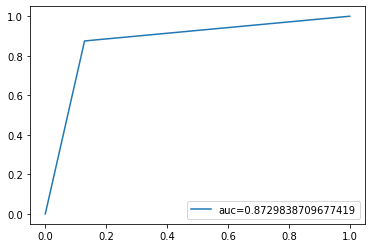

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt

fpr, tpr, _ = metrics.roc_curve(y_test, predicted_output)
auc = metrics.roc_auc_score(y_test, predicted_output)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_output, labels=[0,1])


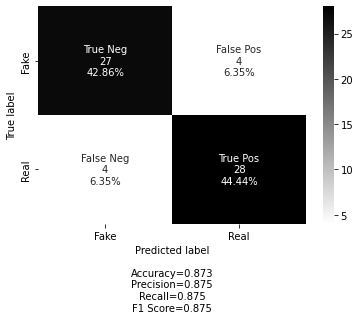

In [ ]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Fake", "Real"]
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap="binary")